In [3]:
import stompy.model.delft.dflow_model as dfm
import numpy as np
import pandas as pd
import xarray as xr
from stompy.grid import multi_ugrid
import os
import six
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
six.moves.reload_module(dfm)

<module 'stompy.model.delft.dflow_model' from '/home/rustyh/src/stompy/stompy/model/delft/dflow_model.py'>

In [5]:
fig_dir="fig-scenarios-20220402"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [4]:
# Start with 2D runs
runs=pd.DataFrame(dict(run_dir=['data_2016_2d_asbuilt_impaired',
                                'data_2016_2d_asbuilt_impaired_scen1-v001',
                                'data_2016_2d_asbuilt_impaired_scen2-v001',
                                'data_2016_2d_asbuilt_impaired_scen3-v001'],
                       name=['Base','Low','Medium','High']))


In [5]:
runs['model']=runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

runs['his']=runs.model.apply(lambda mod: mod.his_dataset())

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist
node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist
node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist
Some lines are degenerate


Preliminary 2D plots:

First step is to verify that the scenarios are working as planned.
 - time series of waterlevel at key locations
 
Second step is to go through the analyses in the scope:
 - which can be handled in 2D
 - do any require more output than is currently configured?
 


In [6]:
stage_stations=[ ['thalweg_pesc_0000','Ocean'],
                 ['nck','Lagoon'],
                 ['pch_up','Culverts (N)'],
                 ['nmp','North Marsh Panne'],
                 ['npc','Ped. Bridge']]

In [7]:
def fig_waterlevel_timeseries(rec):
    fig,ax=plt.subplots(1,1,figsize=(7.5,4))

    his=rec['model'].his_dataset()
    
    for station,name in stage_stations:
        ax.plot(his.time,
                his.waterlevel.sel(stations=station),
                label=name)

    ax.legend(loc='upper left',bbox_to_anchor=[1.03,1])
    fig.subplots_adjust(right=0.72,left=0.1,top=0.98)
    ax.set_ylabel('Stage (m)')
    ax.text(0.03,0.97,rec['name'],transform=ax.transAxes,ha='left',va='top')
    fig.autofmt_xdate()
    return fig

<IPython.core.display.Javascript object>


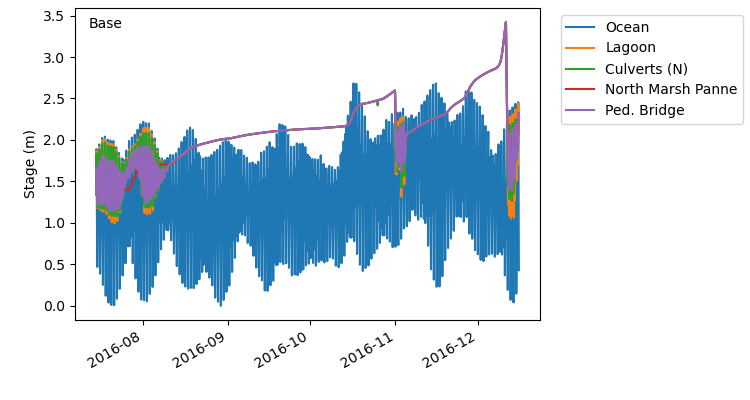

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


<IPython.core.display.Javascript object>


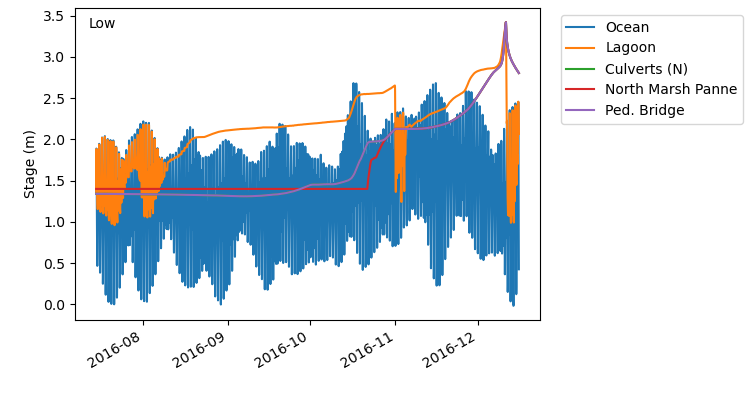

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


<IPython.core.display.Javascript object>


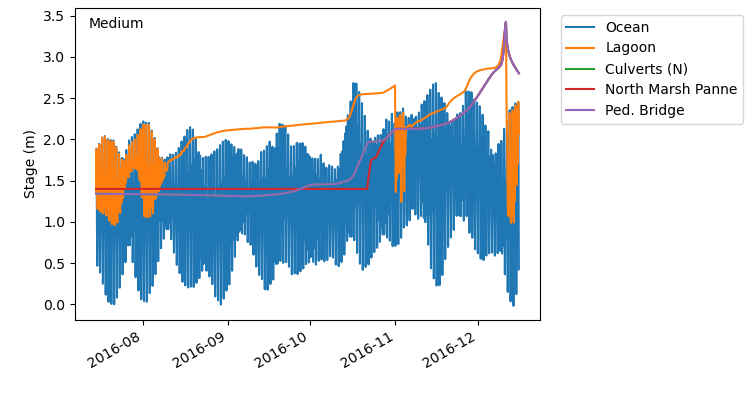

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


<IPython.core.display.Javascript object>


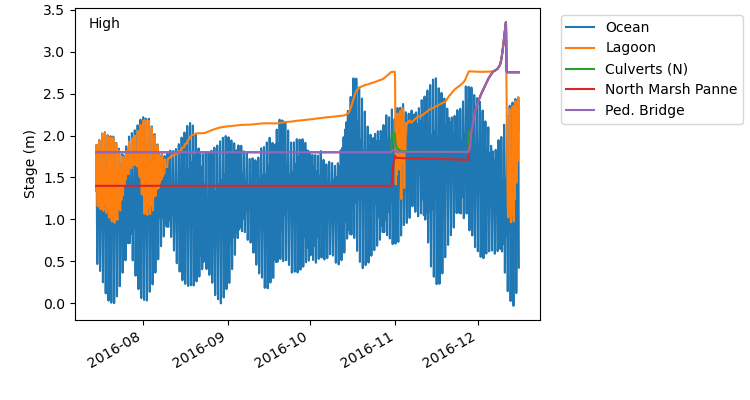

Some lines are degenerate


In [8]:
for _,rec in runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f'stage-timeseries-2016-{rec.name}.png'),
                dpi=150)

Tidal Analysis
--

Bed stress

For bed stress, probably best to choose a day and re-run with half-hour output. Choose
2016-08-03 to 2016-08-05. Restarts are every 10 days, with one falling on 2016-08-04.

Tidal prism



In [9]:
# Start with 2D runs
tidal_runs=pd.DataFrame([
    dict(name='Base',run_dir='data_2016_2d_asbuilt_impaired/flowfmrtidal.mdu'),
    dict(name='Low', run_dir='data_2016_2d_asbuilt_impaired_scen1-v001/flowfmrtidal.mdu'),
    dict(name='Medium',run_dir='data_2016_2d_asbuilt_impaired_scen2-v001/flowfmrtidal.mdu'),
    dict(name='High',run_dir='data_2016_2d_asbuilt_impaired_scen3-v001/flowfmrtidal.mdu')
])

In [10]:
tidal_runs['model']=tidal_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))

<IPython.core.display.Javascript object>


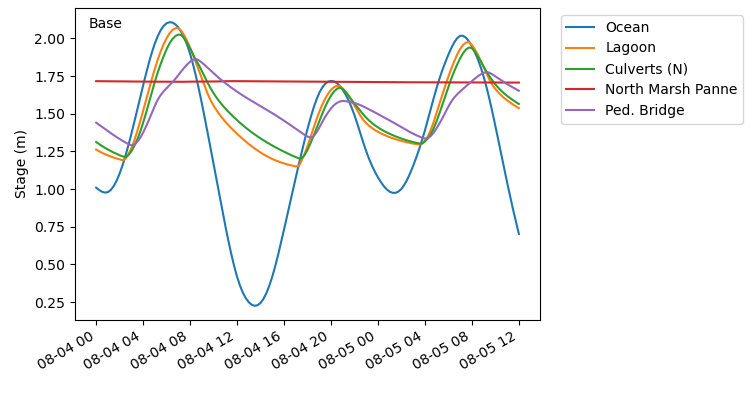

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


<IPython.core.display.Javascript object>


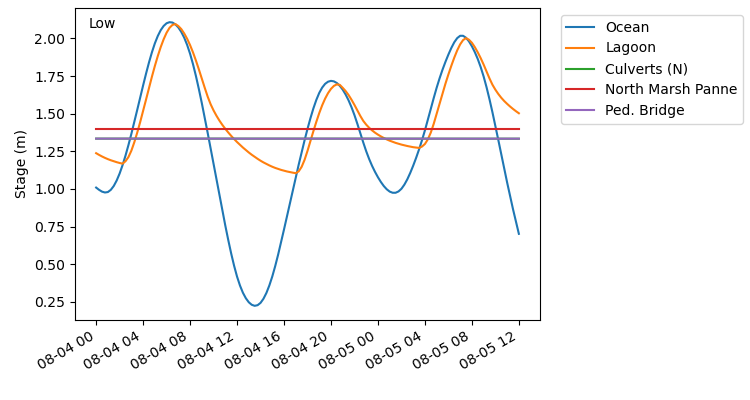

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


<IPython.core.display.Javascript object>


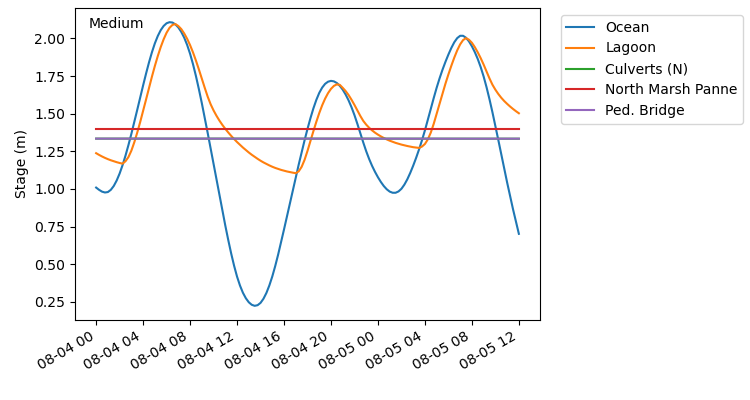

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


<IPython.core.display.Javascript object>


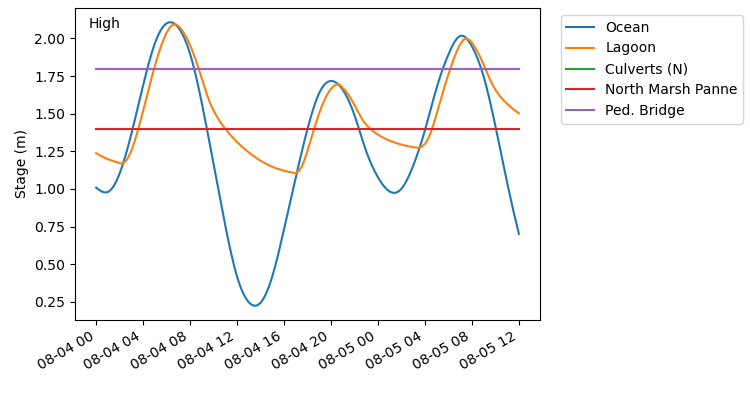

Some lines are degenerate


In [11]:
for _,rec in tidal_runs.iterrows():
    fig=fig_waterlevel_timeseries(rec) 
    fig.savefig(os.path.join(fig_dir,f'tidal36h-stage-timeseries-2016-{rec.name}.png'),
                dpi=150)

In [12]:
# Choose an ebb period and a flood period
ebb_period=[np.datetime64('2016-08-04 06:30:00'),
            np.datetime64('2016-08-04 13:30:00')]
flood_period=[np.datetime64('2016-08-04 13:30:00'),
              np.datetime64('2016-08-04 20:00:00')]

In [13]:
tidal_runs['ebb_sel']=None
tidal_runs['flood_sel']=None

grid=None
for _,rec in tidal_runs.iterrows():
    ds=rec['model'].map_dataset(grid=grid)
    if grid is None:
        grid=ds.grid # so everybody matches the same grid
    rec['ebb_sel']=(ebb_period[0]<=ds.time.values)&(ds.time.values<=ebb_period[1])
    rec['flood_sel']=(flood_period[0]<=ds.time.values)&(ds.time.values<=flood_period[1])


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removin

Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!


INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!
Add ghost handling!


<IPython.core.display.Javascript object>


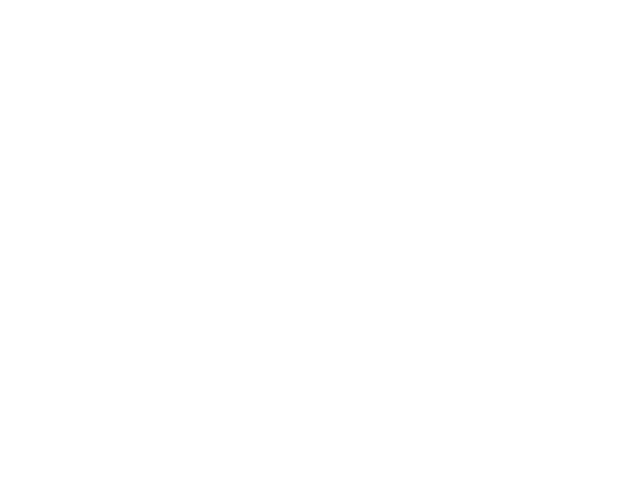

<IPython.core.display.Javascript object>


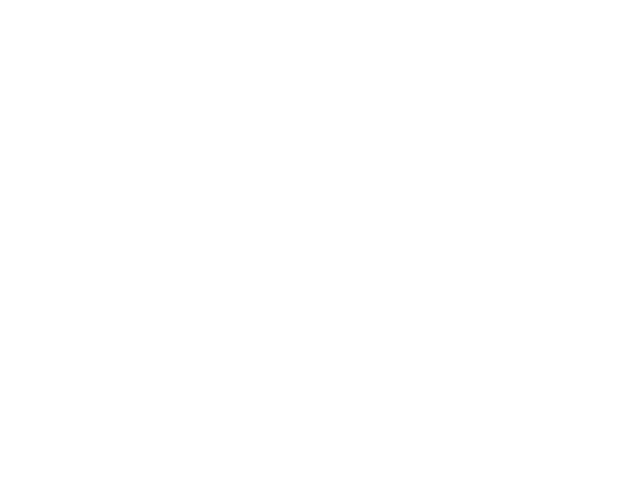

<IPython.core.display.Javascript object>


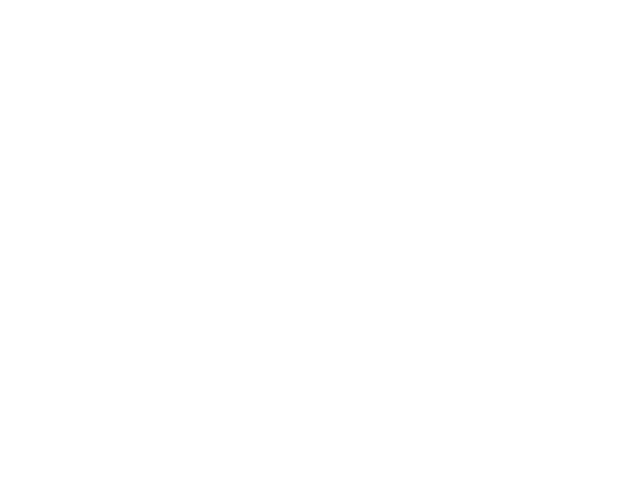

<IPython.core.display.Javascript object>


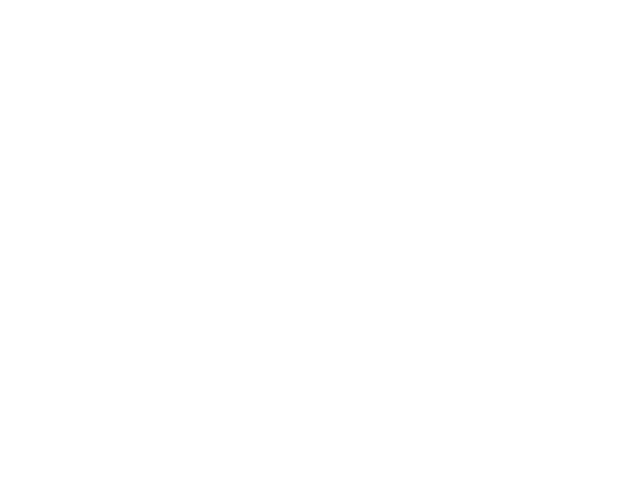

<IPython.core.display.Javascript object>


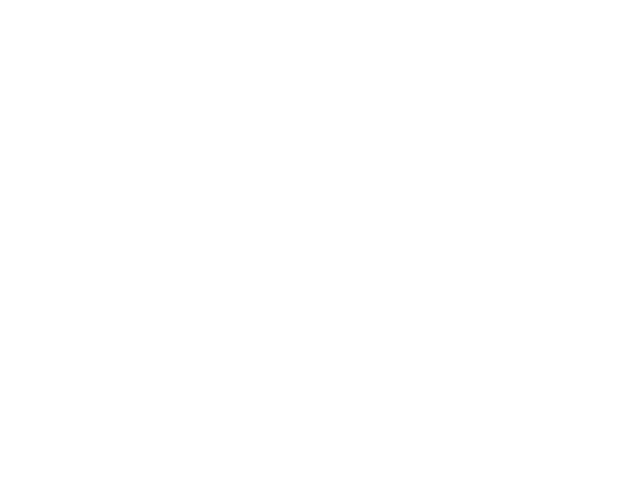

<IPython.core.display.Javascript object>


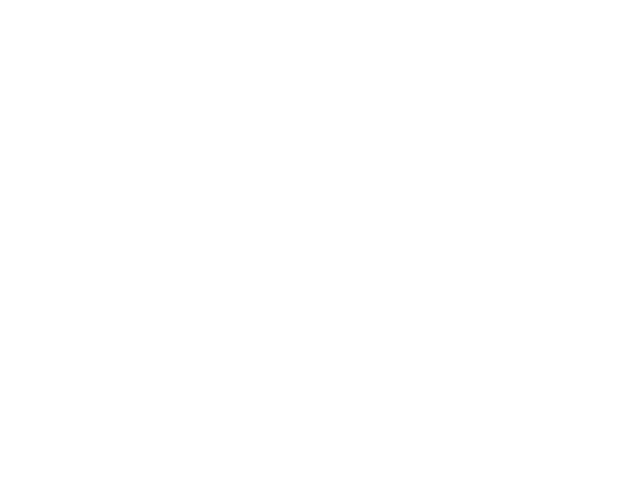

<IPython.core.display.Javascript object>


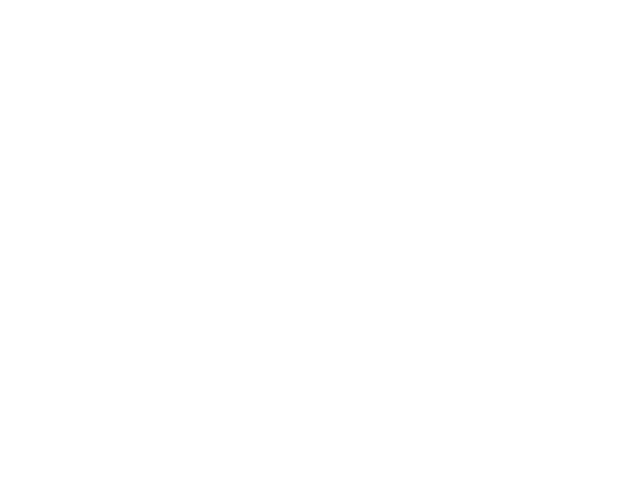

<IPython.core.display.Javascript object>


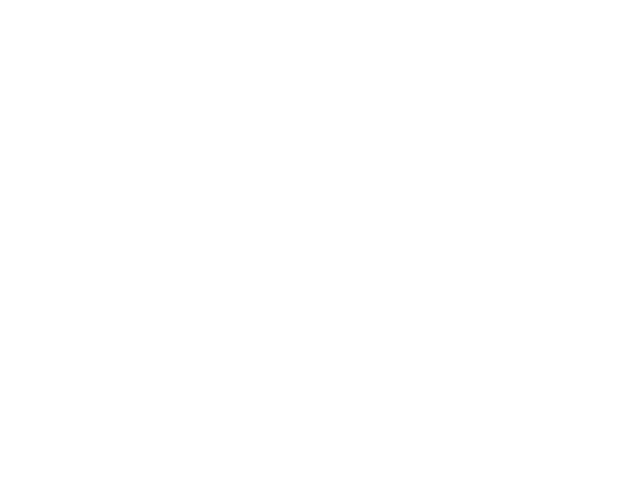

In [14]:
# mean and max bed stress for each of the runs, for flood and ebb
from matplotlib import colors
zoom=[552085, 552647.,4124191, 4125112]


for _,rec in tidal_runs.iterrows():
    ds=rec['model'].map_dataset()

    for sel,period_name in [ (rec['ebb_sel'],'ebb'),
                             (rec['flood_sel'],'flood')]:
        
        tau=ds['mesh2d_taus'].isel(time=sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        fig,axs=plt.subplots(1,2)
        for ax,vals,label in zip(axs,
                                  [tau_max,tau_mean],
                                  ['Max. bed stress (Pa)','Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            #ccoll=ds.grid.plot_cells(values=vals,cmap='turbo',ax=ax)
            #ccoll.set_clim([0,10])
            ccoll=ds.grid.plot_cells(values=vals.clip(0.1),cmap='turbo',ax=ax,norm=colors.LogNorm())
            ccoll.set_clim([0.1,10])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(zoom)
        fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)
        fig.savefig(os.path.join(fig_dir,f'bed_stress-{rec.name}-{period_name}.png'),dpi=200)
    

Skip base==base


<IPython.core.display.Javascript object>


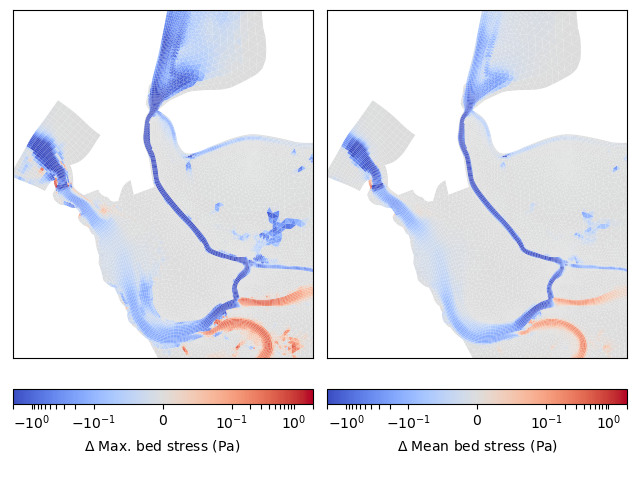

<IPython.core.display.Javascript object>


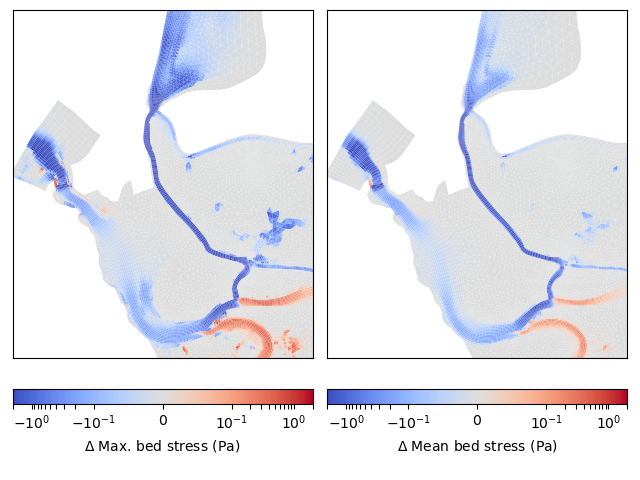

<IPython.core.display.Javascript object>


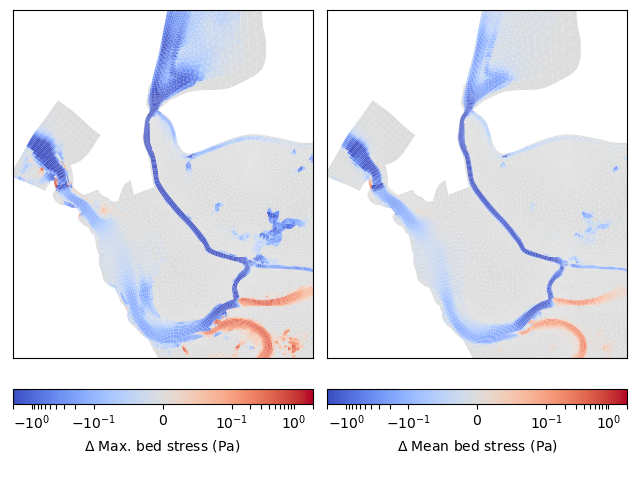

Skip base==base


<IPython.core.display.Javascript object>


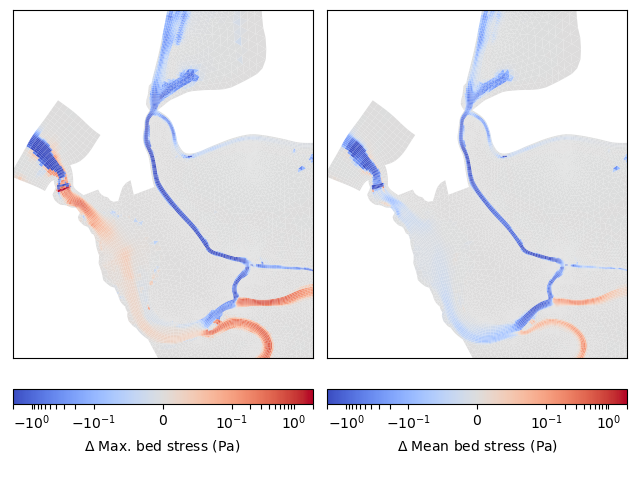

<ipython-input-18-b2029b0330a4>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,axs=plt.subplots(1,2)


<IPython.core.display.Javascript object>


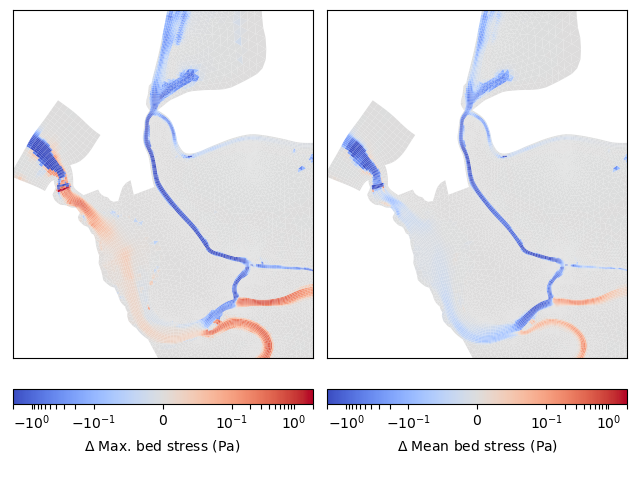

<IPython.core.display.Javascript object>


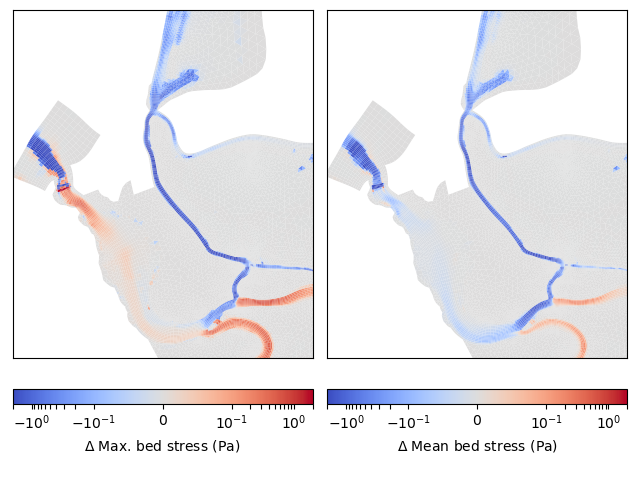

In [18]:
# Compare mean bed stress, per tidal phase, between each scenario
# and the base

zoom=[552085, 552647.,4124191, 4125112]

ds_base=tidal_runs.model.values[0].map_dataset()
ebb_sel_base=tidal_runs.ebb_sel.values[0]
flood_sel_base=tidal_runs.flood_sel.values[0]
tau_base=ds_base['mesh2d_taus']


for sel,period_name in [ (rec['ebb_sel'],'ebb'),
                         (rec['flood_sel'],'flood')]:
    if period_name=='ebb':
        tau=ds_base['mesh2d_taus'].isel(time=ebb_sel_base).values
    elif period_name=='flood':
        tau=ds_base['mesh2d_taus'].isel(time=flood_sel_base).values
        
    tau_max_base =np.nanmax(tau, axis=0)
    tau_mean_base=np.mean(tau,axis=0)
    
    for _,rec in tidal_runs.iterrows():
        ds=rec['model'].map_dataset()
        if ds==ds_base:
            print("Skip base==base")
            continue
        
        tau=ds['mesh2d_taus'].isel(time=sel).values
        tau_max=np.nanmax(tau, axis=0)
        tau_mean=np.mean(tau,axis=0)
        fig,axs=plt.subplots(1,2)
        for ax,vals,label in zip(axs,
                                 [tau_max-tau_max_base,
                                  tau_mean-tau_mean_base],
                                 [r'$\Delta$ Max. bed stress (Pa)',
                                  r'$\Delta$ Mean bed stress (Pa)']):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)

            ccoll=ds.grid.plot_cells(values=vals,cmap='coolwarm',ax=ax,
                                    norm=colors.SymLogNorm(0.1,vmin=-5,vmax=5,base=10))
            ccoll.set_clim([-2,2])

            plt.colorbar(ccoll,ax=ax,label=label,pad=0.07,orientation='horizontal')
            ax.axis(zoom)
        fig.subplots_adjust(left=0.02,right=0.98,top=0.98,bottom=0.05,wspace=0.05,hspace=0.05)
        fig.savefig(os.path.join(fig_dir,f'bed_stress-diff-{rec.name}-{period_name}.png'),dpi=200)
        

Tidal Prism Figures
---

In [26]:
# Given a time and a history dataset, extract the prism from each cross-section
his_ds=tidal_runs.model.values[0].his_dataset()

ebb_time=ebb_period[0]+(ebb_period[1]-ebb_period[0])/2
# model:
#  - extract the tidal prism from each cross-section
#  -

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


In [39]:
def extract_volumes(his_ds,mid_time):
    prism_ds=xr.Dataset()
    prism_ds['cross_section']=his_ds.cross_section

    volumes=[]
    for i,section in enumerate(his_ds.cross_section.values):
        #print(section)
        flow=his_ds['cross_section_discharge'].isel(cross_section=i).values
        ti_mid=np.searchsorted(his_ds.time.values,mid_time)
        flow_mid=flow[ti_mid]
        ti_start=ti_mid
        while (flow[ti_start-1]*flow_mid>0) and (ti_start>0): ti_start-=1
        ti_stop=ti_mid
        while (flow[ti_stop]*flow_mid>0) and (ti_stop+1<len(flow)): ti_stop+=1
        dt=(his_ds.time.values[2]-his_ds.time.values[1])/np.timedelta64(1,'s')
        volume=flow[ti_start:ti_stop].sum() * dt
        #print(f"{section}: {volume:.1f} m3")
        volumes.append(volume)

    prism_ds['volume']=('cross_section',),volumes
    prism_ds['volume'].attrs['units']='m3'
    return prism_ds

In [ ]:
# Prism table:
# select and label cross sections
section_sel={'mouth_xs':'Mouth',
             'n_complex_xs':'NM Complex',
             'n_ditch_xs':'NM N Ditch',
             'n_pond_xs':'N Pond',
             'butano_lower_xs':'Butano Ck',
             'pesca_lower_xs':'Pescadero Ck'}

prisms=[]
for _,row in tidal_runs.iterrows():
    ds=extract_volumes(row['model'].his_dataset(),ebb_time)
    ds['run']=(),row['name']
    prisms.append(ds)
prisms=xr.concat(prisms,dim='run').to_dataframe()
prisms

In [61]:
df=prisms['volume'].unstack().reset_index()
df=df[ df.cross_section.isin(section_sel)].copy()

df['Cross section']=df['cross_section'].map(section_sel)
df=df.set_index('Cross section')
del df['cross_section']
df.to_csv(os.path.join(fig_dir,"ebb-prisms.csv"))
df

run,Base,High,Low,Medium
Cross section,,,,
Butano Ck,59235.951190,63712.282092,63712.936499,63711.980049
Mouth,192439.185263,175230.175615,175232.819548,175231.814081
NM Complex,-42916.747719,-82.337585,-82.311411,-82.253103
NM N Ditch,4871.503699,0.000000,-0.003707,-0.003731
N Pond,31111.572382,0.016958,0.314835,0.314941
Pescadero Ck,87001.096115,60578.885790,60579.514323,60579.129084


Freshening
----

Time for depth-averaged salinity to reach 5ppt, after closure.

In [7]:
# Runs are restarting, but can test with this older run, which
# has 53d completed.
fresh_runs=pd.DataFrame(dict(run_dir=['data_2016long_3d_asbuilt_impaired_scen1-v001'],
                             name=['Low']))

fresh_runs['model']=fresh_runs.run_dir.apply(lambda rd: dfm.DFlowModel.load(rd))
fresh_runs['his']=fresh_runs.model.apply(lambda mod: mod.his_dataset())

node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


In [8]:
# First, just use the map output
for _,row in fresh_runs.iterrows():
    model=row['model']
    mds=model.map_dataset()
    break
    

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


<IPython.core.display.Javascript object>


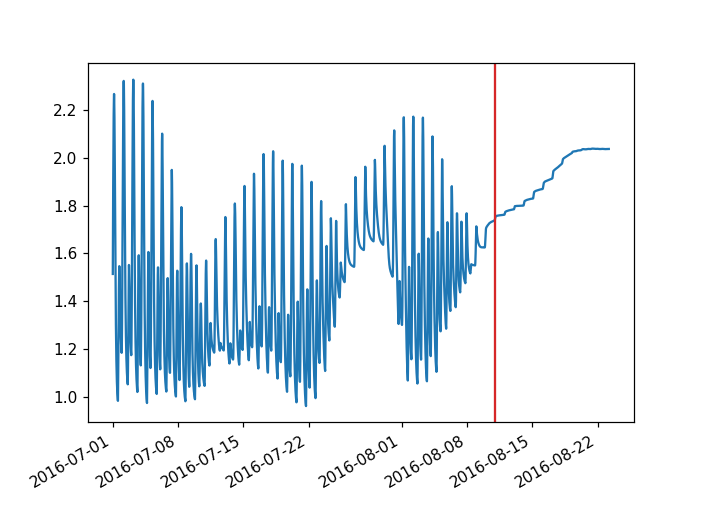

In [17]:
# When did it close?  Hopefully all of the runs will use the same starting
# time, so we can reuse the closure timing
t_close=np.datetime64("2016-08-11 00:00")

nck=row['his'].waterlevel.sel(stations='nck')
fig,ax=plt.subplots()
ax.plot(nck.time, nck)
ax.axvline(t_close,color='tab:red')
fig.autofmt_xdate()

In [109]:
from stompy.grid import ugrid
six.moves.reload_module(ugrid)

def s_davg(ti):
    snap=mds.isel(time=ti)
    salt=snap['mesh2d_sa1'].values
    
    ug=ugrid.UgridXr(snap,layer_dim='mesh2d_nLayers',face_eta_vname='mesh2d_s1',
                     layer_vname='mesh2d_layer_z')
    weights=ug.vertical_averaging_weights(ztop=0,zbottom=0)
    s_davg=np.nansum(weights*salt,axis=1)
    dry=np.all(np.isnan(weights),axis=1)
    s_davg[dry]=np.nan
    return s_davg

def calc_days_to_freshen(mds,t_close,s_thresh=5.0):
    ti_close=np.searchsorted(mds.time.values,t_close)
    
    t_fresh=np.nan*np.ones(mds.grid.Ncells())
    time_vals=mds.time.values
    t0=time_vals[ti_close]

    for ti in range(ti_close,mds.dims['time']):
        print(ti)    
        salt_i=s_davg(ti)
        fresh=(salt_i<s_thresh) & np.isnan(t_fresh)
        t_fresh[fresh]=(time_vals[ti]-t0)/np.timedelta64(86400,'s')
    return t_fresh

In [110]:
t_fresh=calc_days_to_freshen(mds,t_close)

21
22
23
24
25
26


In [96]:
# Survey initial, depth-averaged salinity field
salt0=s_davg(ti_close)

fig,ax=plt.subplots()
ax.set_adjustable('datalim')
mds.grid.plot_cells(values=salt0,cmap='turbo',clim=[0,34])

<IPython.core.display.Javascript object>


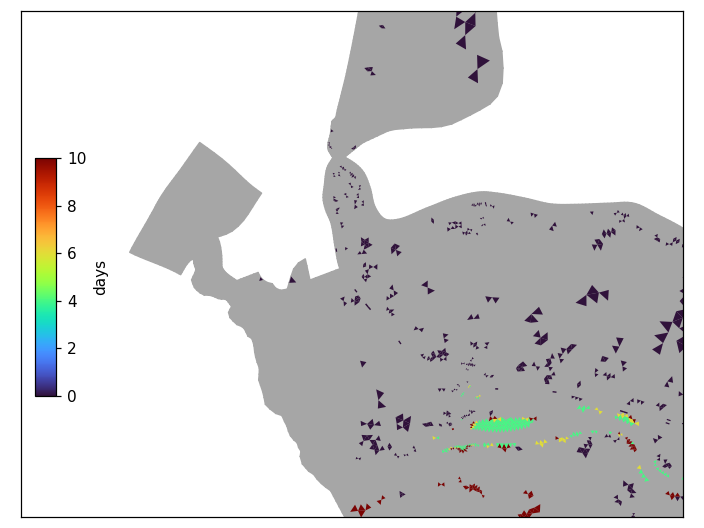

(552085.0, 552647.0, 4124191.0, 4125112.0)

In [111]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
mds.grid.plot_cells(color='0.65',zorder=-1)
ccoll=mds.grid.plot_cells(values=t_fresh,mask=np.isfinite(t_fresh),cmap='turbo',zorder=1)
ax.xaxis.set_visible(0)
ax.yaxis.set_visible(0)
fig.subplots_adjust(left=0.03,right=0.97,top=0.98,bottom=0.02)
cax=fig.add_axes([0.05,0.25,0.03,0.45])
plt.colorbar(ccoll,cax=cax,label="days")
zoom=[552085, 552647.,4124191, 4125112]
ax.axis(zoom)